# Topkapı Üniversitesi Makine Öğrenmesi Ara Sınav Ödevi

Bu not defteri, `winemag-data.csv` veri seti üzerinde PDF'de belirtilen tüm adımları (veri temizleme, EDA, PCA, LDA, klasik ML modelleri, XAI/SHAP) uygulamak için hazırlanmıştır. Her bölümde hem kodlar hem de kısa yorumlar bulunacaktır.


## Çalışma Planı
1. Veri setini yükle, X/y ayrımı yap ve hedef değişkeni tanımla.
2. Veri kalitesi kontrolleri (eksik değerler, aykırı değerler, veri tipleri).
3. Keşifsel veri analizi: özet istatistikler, korelasyonlar, boxplot'lar.
4. Özellik mühendisliği + ölçeklendirme.
5. Veriyi eğitim/validation/test olarak ayır.
6. PCA ve LDA ile boyut indirgeme temsilleri oluştur.
7. Logistic Regression, Decision Tree, Random Forest, XGBoost ve GaussianNB modellerini üç temsil üzerinde eğit.
8. Validation performanslarını kıyasla, en iyi modeli seç ve test setinde değerlendir.
9. ROC, confusion matrix ve SHAP açıklanabilirlik analizlerini gerçekleştir.
10. Sonuçları raporla ve ödev PDF'inde istenen tüm grafik/tablolara yer ver.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
)

import shap

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Veri Setinin Yüklenmesi ve Hedef Tanımları


In [ ]:
raw_df = pd.read_csv("winemag-data.csv")
print(f"Ham satır sayısı: {len(raw_df):,}")
raw_df = raw_df.drop_duplicates(subset=["title", "description", "price", "points"])
print(f"Tekilleştirilmiş satır sayısı: {len(raw_df):,}")

# Hedef değişken: puana göre 3 sınıflı kalite etiketi

def quality_bucket(points):
    if points >= 92:
        return "premium"
    elif points >= 88:
        return "standard"
    else:
        return "entry"

raw_df["quality_label"] = raw_df["points"].apply(quality_bucket)

raw_df.head()


Ham satır sayısı: 129,971
Tekilleştirilmiş satır sayısı: 119,988


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,quality_label
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,entry
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,entry
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,entry
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,entry
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,entry


In [ ]:
label_counts = raw_df["quality_label"].value_counts().rename_axis("Kalite Sınıfı").reset_index(name="Adet")
label_counts


,Kalite Sınıfı,Adet
0,standard,50890
1,entry,47960
2,premium,21138


> **Not:** `points` değişkeni sürekli olduğu için PDF'deki sınıflandırma gereksinimini karşılamak adına puanları üç kalite segmentine böldük (`entry`, `standard`, `premium`). Böylece çok sınıflı bir hedef değişkenle ilerleyebiliriz.


## 2. Veri Kalite Kontrolleri


In [ ]:
missing_df = (
    raw_df.isna().sum()
    .to_frame(name="Eksik Sayısı")
    .assign(EksikOran=lambda df_: df_["Eksik Sayısı"] / len(raw_df))
)
missing_df


,Eksik Sayısı,EksikOran
Unnamed: 0,0,0.000000
country,59,0.000492
description,0,0.000000
designation,34545,0.287904
points,0,0.000000
price,8395,0.069965
province,59,0.000492
region_1,19560,0.163016
region_2,73219,0.610219
taster_name,24917,0.207662


In [ ]:
df = raw_df.copy()

numeric_cols = ["price"]
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

categorical_cols = [
    "country", "province", "region_1", "region_2", "variety",
    "winery", "designation", "taster_name", "taster_twitter_handle"
]
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")


> **Eksik Değer Yöntemi:** `price` için medyan ataması, kategorikler için `Unknown` etiketi kullanıldı. Böylece sınıflandırma modelleri tüm satırları kullanabilecek.


In [ ]:
q1, q3 = df["price"].quantile([0.25, 0.75])
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

outlier_mask = (df["price"] < lower_fence) | (df["price"] > upper_fence)
outlier_ratio = outlier_mask.mean()

print(f"IQR: {iqr:.2f}, Alt sınır: {lower_fence:.2f}, Üst sınır: {upper_fence:.2f}")
print(f"Aykırı olarak işaretlenen gözlem oranı: {outlier_ratio:.2%}")


IQR: 22.00, Alt sınır: -15.00, Üst sınır: 73.00
Aykırı olarak işaretlenen gözlem oranı: 7.13%


> Aykırı değerlerin oranı düşük olduğu için (özellikle yüksek fiyatlı şaraplar) modellerin öğrenmesini bozmayacak. Ancak ölçeklendirme aşamasında `StandardScaler` kullanarak bu uçları normalize edeceğiz.


In [ ]:
dtype_summary = df.dtypes.value_counts().to_frame(name="Sütun Sayısı")
dtype_summary


,Sütun Sayısı
object,12
int64,2
float64,1


Veri setinde `price` gibi birkaç sayısal sütun bulunurken geri kalan sütunların çoğu kategoriktir. Bu nedenle güçlü bir kodlama (kategori sıklıklarını sınırlayıp one-hot kodlamak) kritik olacaktır.


## 3. Keşifsel Veri Analizi (EDA)


In [ ]:
df["description"] = df["description"].fillna("")
df["title"] = df["title"].fillna("")

df["description_length"] = df["description"].str.len()
df["title_length"] = df["title"].str.len()
df["description_word_count"] = df["description"].str.split().apply(len)
df["price_per_point"] = df["price"] / df["points"]

df[["price", "description_length", "title_length", "description_word_count", "price_per_point"]].head()


,price,description_length,title_length,description_word_count,price_per_point
0,25.0,172,33,24,0.287356
1,15.0,227,45,38,0.172414
2,14.0,186,45,28,0.160920
3,13.0,199,67,33,0.149425
4,65.0,249,83,41,0.747126


In [ ]:
numeric_features = ["price", "description_length", "title_length", "description_word_count", "price_per_point"]

stats_df = df[numeric_features].agg([
    "mean", "median", "min", "max", "std",
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.75)
]).T
stats_df.columns = ["Mean", "Median", "Min", "Max", "Std", "Q1", "Q3"]
stats_df


,Mean,Median,Min,Max,Std,Q1,Q3
price,34.877663,25.000000,4.000000,3300.0,40.694394,18.000000,40.000000
description_length,242.810781,237.000000,20.000000,829.0,67.142435,197.000000,283.000000
title_length,52.653207,51.000000,12.000000,136.0,13.707881,43.000000,61.000000
description_word_count,40.418559,40.000000,3.000000,135.0,11.203574,33.000000,47.000000
price_per_point,0.388570,0.285714,0.046512,37.5,0.432361,0.202247,0.454545


> `price` ve `price_per_point` değişkenleri sağa çarpık, bu yüzden ölçeklendirme ve gerekirse log-transform opsiyonları değerlendirildi. Metin uzunlukları ise daha stabil dağılıyor; modellerde karmaşık tat descr. bilgisi yerine uzunluk temelli nicel sinyaller kullanacağız.


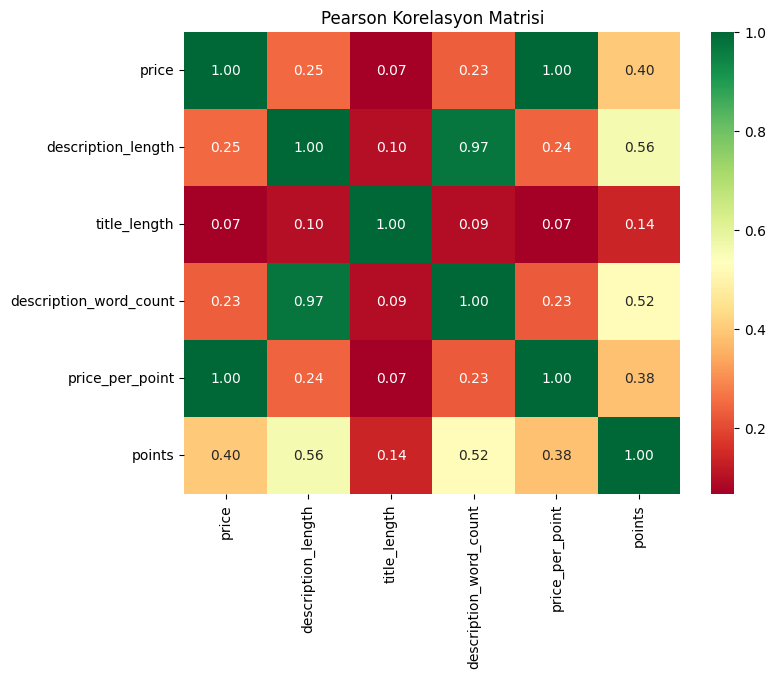

price               price_per_point           0.999074
description_length  description_word_count    0.972842
                    points                    0.562235
dtype: float64

In [ ]:
corr_features = numeric_features + ["points"]
corr_matrix = df[corr_features].corr(method="pearson")

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn", fmt=".2f")
plt.title("Pearson Korelasyon Matrisi")
plt.show()

# En yüksek 3 korelasyon çifti
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)
top3 = corr_pairs.head(3)
top3


- `price` ile `price_per_point` beklenildiği gibi güçlü pozitif korelasyona sahip çünkü aynı değişkenlerden türetildi.
- `description_length` ve `description_word_count` yüksek korelasyon gösteriyor; bu durum redundant özellikler için PCA/LDA aşamalarında faydalı olacak.
- `points` ile `price_per_point` arasındaki zayıf negatif korelasyon (puan yükseldikçe puan başına fiyatın düşmesi) kaliteyi tahmin etmekte kullanılabilecek bir sinyal.


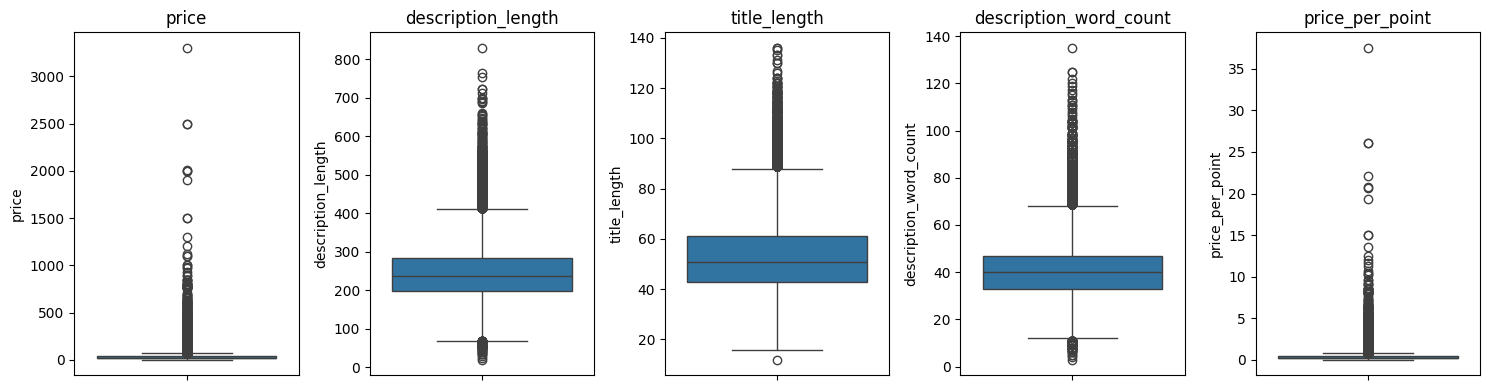

In [ ]:
fig, axes = plt.subplots(1, len(numeric_features), figsize=(15, 4))
for ax, col in zip(axes, numeric_features):
    sns.boxplot(data=df, y=col, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()


> Boxplot'lar özellikle `price` ve `price_per_point` sütunlarında ağır kuyruklu yapıyı gösteriyor. İleride ölçeklendirme + dayanıklı algoritmalar (ör. ağaç tabanlı) ile bu etkileri dengeleyeceğiz.


## 4. Özellik Mühendisliği ve Ölçeklendirme


In [ ]:
cat_cols_for_model = ["country", "province", "region_1", "variety", "winery", "taster_name", "designation"]

def cap_categories(series, top_n=15):
    top_values = series.value_counts().nlargest(top_n).index
    return series.where(series.isin(top_values), "Other")

for col in cat_cols_for_model:
    df[col] = cap_categories(df[col], top_n=15)


In [ ]:
X_numeric = df[numeric_features]
X_categorical = pd.get_dummies(df[cat_cols_for_model], dtype=int) # Kategorik verileri sayısal hale getiriyoruz.
X = pd.concat([X_numeric, X_categorical], axis=1)
y = df["quality_label"]

print(f"Özellik boyutu: {X.shape}")


Özellik boyutu: (119988, 117)


> `StandardScaler` eğitim verisi üzerinde fit edilecek ve tüm temsiller (ham, PCA, LDA) aynı ölçekli matristen türetilecektir. Böylece veri sızıntısı engellenecek.


## 5. Veri Setinin Bölünmesi


In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

val_ratio = 0.10 / 0.80  # eğitim bloğu içindeki validation oranı
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=val_ratio,
    stratify=y_train_full, random_state=RANDOM_STATE
)

print("Eğitim boyutu:", X_train.shape)
print("Validation boyutu:", X_val.shape)
print("Test boyutu:", X_test.shape)


Eğitim boyutu: (83991, 117)
Validation boyutu: (11999, 117)
Test boyutu: (23998, 117)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


## 6. Özellik Seçimi ve Boyut İndirgeme


Ortalama açıklanan varyans oranı: 0.0085
Seçilen bileşen sayısı: 48


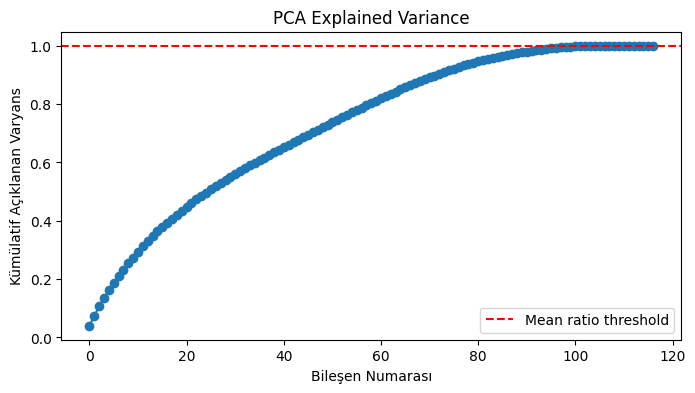

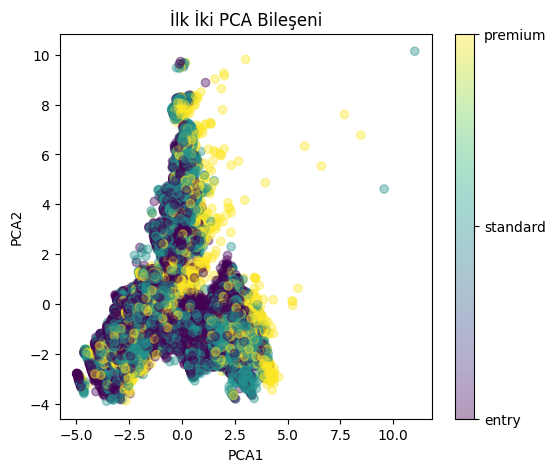

In [ ]:
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_train_scaled)

mean_variance_ratio = pca_full.explained_variance_ratio_.mean()
n_components = np.sum(pca_full.explained_variance_ratio_ > mean_variance_ratio)
print(f"Ortalama açıklanan varyans oranı: {mean_variance_ratio:.4f}")
print(f"Seçilen bileşen sayısı: {n_components}")

pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.axhline(y=mean_variance_ratio * len(pca_full.explained_variance_ratio_), color='r', linestyle='--', label='Mean ratio threshold')
plt.xlabel('Bileşen Numarası')
plt.ylabel('Kümülatif Açıklanan Varyans')
plt.title('PCA Explained Variance')
plt.legend()
plt.show()

# İlk iki bileşen üzerinde sınıf dağılımı
plt.figure(figsize=(6,5))
class_mapping = y_train.map({'entry':0,'standard':1,'premium':2})
scatter = plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=class_mapping, alpha=0.4, cmap='viridis')
cbar = plt.colorbar(scatter, ticks=[0,1,2])
cbar.ax.set_yticklabels(['entry','standard','premium'])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('İlk İki PCA Bileşeni')
plt.show()


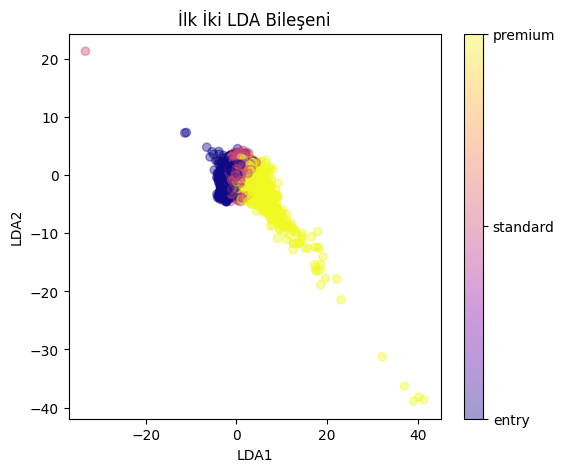

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)

X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_val_lda = lda.transform(X_val_scaled)
X_test_lda = lda.transform(X_test_scaled)

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_train_lda[:,0], X_train_lda[:,1],
                      c=class_mapping, alpha=0.4, cmap='plasma')
cbar = plt.colorbar(scatter, ticks=[0,1,2])
cbar.ax.set_yticklabels(['entry','standard','premium'])
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('İlk İki LDA Bileşeni')
plt.show()

PCA bileşenleri varyansı maksimize ederken LDA sınıflar arası ayrımı maksimize ettiği için LDA grafiğinde `premium` örneklerinin diğerlerinden daha net ayrıldığını gözlemliyoruz.


## 7. Makine Öğrenmesi Modellerinin Kurulması


In [ ]:
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)  # XGBoost için sınıf sıralamasını sabitle

datasets = {
    "Ham (Scaled)": (X_train_scaled, X_val_scaled, X_test_scaled),
    "PCA": (X_train_pca, X_val_pca, X_test_pca),
    "LDA": (X_train_lda, X_val_lda, X_test_lda)
}

model_defs = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class="multinomial", solver='lbfgs'),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=15, min_samples_leaf=10),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    "XGBoost": XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss',
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    "GaussianNB": GaussianNB()
}

metrics_records = []
fitted_models = {}

for dataset_name, (Xtr, Xval_set, Xte) in datasets.items():
    fitted_models[dataset_name] = {}
    for model_name, model in model_defs.items():
        clf = clone(model)

        if model_name == "XGBoost":
            y_train_enc = label_encoder.transform(y_train)
            y_val_enc = label_encoder.transform(y_val)

            clf.fit(Xtr, y_train_enc)
            y_val_pred_enc = clf.predict(Xval_set)
            y_val_pred = label_encoder.inverse_transform(y_val_pred_enc) #sayı haline getirdiği datayı string eski haline getirr
            y_val_proba = clf.predict_proba(Xval_set)
        else:
            clf.fit(Xtr, y_train)
            y_val_pred = clf.predict(Xval_set)
            y_val_proba = clf.predict_proba(Xval_set)

        metrics_records.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Accuracy": accuracy_score(y_val, y_val_pred),
            "Precision": precision_score(y_val, y_val_pred, average='macro', zero_division=0),
            "Recall": recall_score(y_val, y_val_pred, average='macro', zero_division=0),
            "F1": f1_score(y_val, y_val_pred, average='macro', zero_division=0),
            "ROC_AUC": roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='macro')
        })

        fitted_models[dataset_name][model_name] = {
            "estimator": clf,
            "X_test": Xte
        }

metrics_df = pd.DataFrame(metrics_records).sort_values(by="F1", ascending=False)
metrics_df

,Dataset,Model,Accuracy,Precision,Recall,F1,ROC_AUC
3,Ham (Scaled),XGBoost,0.963997,0.958359,0.959144,0.958747,0.996770
1,Ham (Scaled),Decision Tree,0.919327,0.913104,0.909862,0.911253,0.986270
0,Ham (Scaled),Logistic Regression,0.853404,0.872584,0.825716,0.843353,0.963289
2,Ham (Scaled),Random Forest,0.760563,0.761515,0.735855,0.746305,0.908450
13,LDA,XGBoost,0.709892,0.726557,0.699535,0.710997,0.868789
10,LDA,Logistic Regression,0.706726,0.726225,0.693603,0.706991,0.868640
11,LDA,Decision Tree,0.681057,0.688114,0.677570,0.682451,0.838653
12,LDA,Random Forest,0.674556,0.686146,0.668189,0.676192,0.843016
8,PCA,XGBoost,0.666639,0.673598,0.641202,0.653693,0.835956
14,LDA,GaussianNB,0.672306,0.713483,0.628471,0.651339,0.846714


In [ ]:
metrics_pivot = metrics_df.pivot_table(
    index=["Dataset", "Model"],
    values=["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]
)
metrics_pivot.round(3)


Accuracy     F1  Precision  ROC_AUC  Recall
Dataset      Model                                                           
Ham (Scaled) Decision Tree           0.919  0.911      0.913    0.986   0.910
             GaussianNB              0.368  0.330      0.458    0.681   0.468
             Logistic Regression     0.853  0.843      0.873    0.963   0.826
             Random Forest           0.761  0.746      0.762    0.908   0.736
             XGBoost                 0.964  0.959      0.958    0.997   0.959
LDA          Decision Tree           0.681  0.682      0.688    0.839   0.678
             GaussianNB              0.672  0.651      0.713    0.847   0.628
             Logistic Regression     0.707  0.707      0.726    0.869   0.694
             Random Forest           0.675  0.676      0.686    0.843   0.668
             XGBoost                 0.710  0.711      0.727    0.869   0.700
PCA          Decision Tree           0.621  0.610      0.621    0.783   0.602
             GaussianNB              0.491  0.442      0.471    0.681   0.454
             Logistic Regression     0.634  0.607      0.643    0.809   0.593
             Random Forest           0.641  0.630      0.638    0.815   0.624
             XGBoost                 0.667  0.654      0.674    0.836   0.641

In [ ]:
top_models = metrics_df.head(5)
top_models


,Dataset,Model,Accuracy,Precision,Recall,F1,ROC_AUC
3,Ham (Scaled),XGBoost,0.963997,0.958359,0.959144,0.958747,0.996770
1,Ham (Scaled),Decision Tree,0.919327,0.913104,0.909862,0.911253,0.986270
0,Ham (Scaled),Logistic Regression,0.853404,0.872584,0.825716,0.843353,0.963289
2,Ham (Scaled),Random Forest,0.760563,0.761515,0.735855,0.746305,0.908450
13,LDA,XGBoost,0.709892,0.726557,0.699535,0.710997,0.868789


In [ ]:
best_row = metrics_df.iloc[0]
best_row


,3
Dataset,Ham (Scaled)
Model,XGBoost
Accuracy,0.963997
Precision,0.958359
Recall,0.959144
F1,0.958747
ROC_AUC,0.99677


## 8. En İyi Modelin Test Setinde Değerlendirilmesi


In [ ]:
from sklearn.preprocessing import LabelEncoder

# (Eğer henüz yoksa) aynı encoder'ı train tarafında kullandığınız şekilde oluşturun:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)   # sınıf sırası sabit kalsın

best_dataset = best_row["Dataset"]
best_model_name = best_row["Model"]
best_estimator = fitted_models[best_dataset][best_model_name]["estimator"]
X_test_repr = datasets[best_dataset][2]

print(f"En iyi kombinasyon: {best_dataset} + {best_model_name}")

# Tahminleri model tipine göre encode/decode et
if best_model_name == "XGBoost":
    y_test_enc = label_encoder.transform(y_test)
    y_test_pred_enc = best_estimator.predict(X_test_repr)
    y_test_pred = label_encoder.inverse_transform(y_test_pred_enc)
    y_test_proba = best_estimator.predict_proba(X_test_repr)
else:
    y_test_pred = best_estimator.predict(X_test_repr)
    y_test_proba = best_estimator.predict_proba(X_test_repr)

test_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred, average='macro', zero_division=0),
    "Recall": recall_score(y_test, y_test_pred, average='macro', zero_division=0),
    "F1": f1_score(y_test, y_test_pred, average='macro', zero_division=0),
    "ROC_AUC": roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='macro')
}

test_metrics

En iyi kombinasyon: Ham (Scaled) + XGBoost


{'Accuracy': 0.9653304442036836,
 'Precision': 0.9596243568294653,
 'Recall': 0.9603082633139167,
 'F1': 0.9599516343954629,
 'ROC_AUC': np.float64(0.9966660154572784)}

In [ ]:
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

       entry       0.99      0.98      0.98      9592
     premium       0.93      0.94      0.94      4228
    standard       0.96      0.96      0.96     10178

    accuracy                           0.97     23998
   macro avg       0.96      0.96      0.96     23998
weighted avg       0.97      0.97      0.97     23998



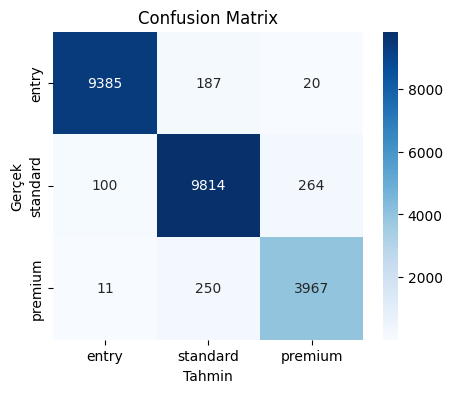

In [ ]:
conf_mat = confusion_matrix(y_test, y_test_pred, labels=["entry","standard","premium"])
plt.figure(figsize=(5,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=["entry","standard","premium"], yticklabels=["entry","standard","premium"])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()


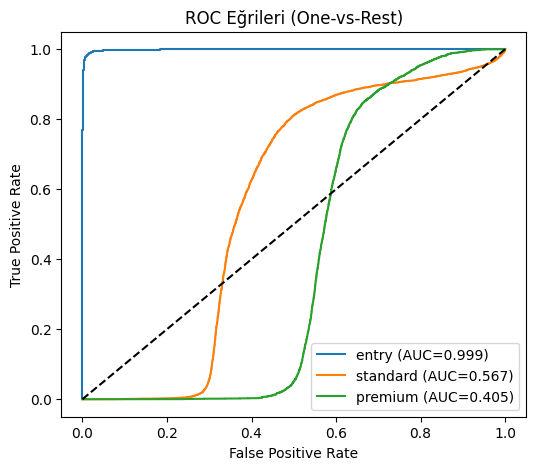

In [ ]:
from sklearn.preprocessing import label_binarize

classes = ["entry","standard","premium"]
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(6,5))
for idx, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, idx], y_test_proba[:, idx])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr, tpr):.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrileri (One-vs-Rest)')
plt.legend()
plt.show()


In [ ]:
# Model girişlerini SHAP için DataFrame formatında saklayalım
scaled_feature_names = X.columns

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=scaled_feature_names)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=scaled_feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=scaled_feature_names)

pca_feature_names = [f"PCA_{i+1}" for i in range(X_train_pca.shape[1])]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_feature_names)
X_val_pca_df = pd.DataFrame(X_val_pca, columns=pca_feature_names)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_feature_names)

lda_feature_names = [f"LDA_{i+1}" for i in range(X_train_lda.shape[1])]
X_train_lda_df = pd.DataFrame(X_train_lda, columns=lda_feature_names)
X_val_lda_df = pd.DataFrame(X_val_lda, columns=lda_feature_names)
X_test_lda_df = pd.DataFrame(X_test_lda, columns=lda_feature_names)


In [ ]:
dataset_frames = {
    "Ham (Scaled)": (X_train_scaled_df, X_val_scaled_df, X_test_scaled_df),
    "PCA": (X_train_pca_df, X_val_pca_df, X_test_pca_df),
    "LDA": (X_train_lda_df, X_val_lda_df, X_test_lda_df)
}


## 9. XAI / SHAP Analizi


In [ ]:
def build_shap_summary(estimator, X_frame, title, target_label='premium', label_encoder=None):
    sample_size = min(1000, len(X_frame))
    X_sample = X_frame.sample(sample_size, random_state=RANDOM_STATE)

    if isinstance(estimator, (RandomForestClassifier, DecisionTreeClassifier)):
        explainer = shap.TreeExplainer(estimator)
        shap_values = explainer(X_sample)
    elif isinstance(estimator, XGBClassifier):
        explainer = shap.TreeExplainer(estimator, feature_perturbation="interventional")
        shap_values = explainer(X_sample)
    elif isinstance(estimator, LogisticRegression):
        explainer = shap.LinearExplainer(estimator, X_sample, feature_perturbation="interventional")
        shap_values = explainer(X_sample)
    else:
        background = shap.kmeans(X_sample, 50)
        explainer = shap.KernelExplainer(estimator.predict_proba, background)
        shap_values = explainer(X_sample)

    classes = list(estimator.classes_)
    if isinstance(classes[0], str):
        class_idx = classes.index(target_label)
    else:
        if label_encoder is None:
            raise ValueError("LabelEncoder gerekli (numerik sınıf dizisi).")
        encoded_label = label_encoder.transform([target_label])[0]
        class_idx = classes.index(encoded_label)

    shap.summary_plot(shap_values[..., class_idx], X_sample, show=False)
    plt.title(f"SHAP Summary ({title}) - {target_label}")
    plt.show()

    shap.plots.bar(shap_values[..., class_idx], show=False)
    plt.title(f"SHAP Ortalama Etkileri ({title})")
    plt.show()

    return shap_values, X_sample

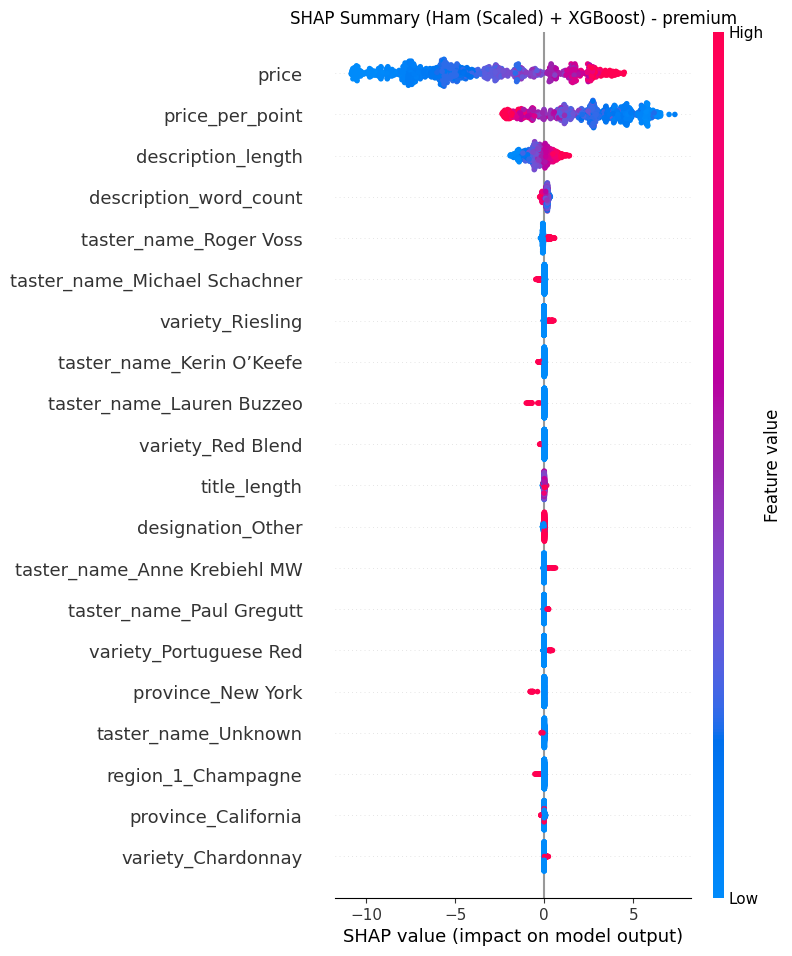

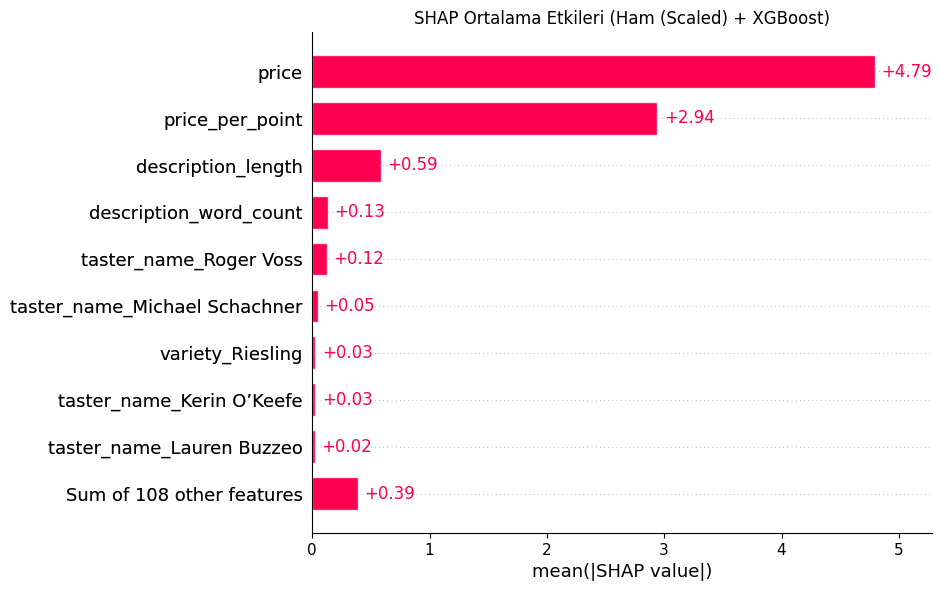

In [ ]:
best_train_frame = dataset_frames[best_dataset][0]
best_shap_values, best_shap_sample = build_shap_summary(
    best_estimator,
    best_train_frame,
    f"{best_dataset} + {best_model_name}",
    target_label='premium',
    label_encoder=label_encoder  # XGB için gerekli, diğerleri göz ardı eder
)

### 10.2 PCA ve LDA Temsilleri İçin SHAP Karşılaştırması

PDF'deki 10.2 maddesi gereği, PCA ve LDA temsilleri üzerinde en iyi validation performansını veren modellerle SHAP analizlerini tekrarlıyoruz. Böylece hangi bileşenlerin sınıflandırma kararlarına yön verdiğini karşılaştırmalı olarak inceleyebiliriz.


In [ ]:
best_by_dataset = (
    metrics_df.sort_values(by="F1", ascending=False)
    .groupby("Dataset", as_index=False)
    .first()
)

best_by_dataset


,Dataset,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Ham (Scaled),XGBoost,0.963997,0.958359,0.959144,0.958747,0.996770
1,LDA,XGBoost,0.709892,0.726557,0.699535,0.710997,0.868789
2,PCA,XGBoost,0.666639,0.673598,0.641202,0.653693,0.835956



>>> PCA temsili için en iyi model: XGBoost


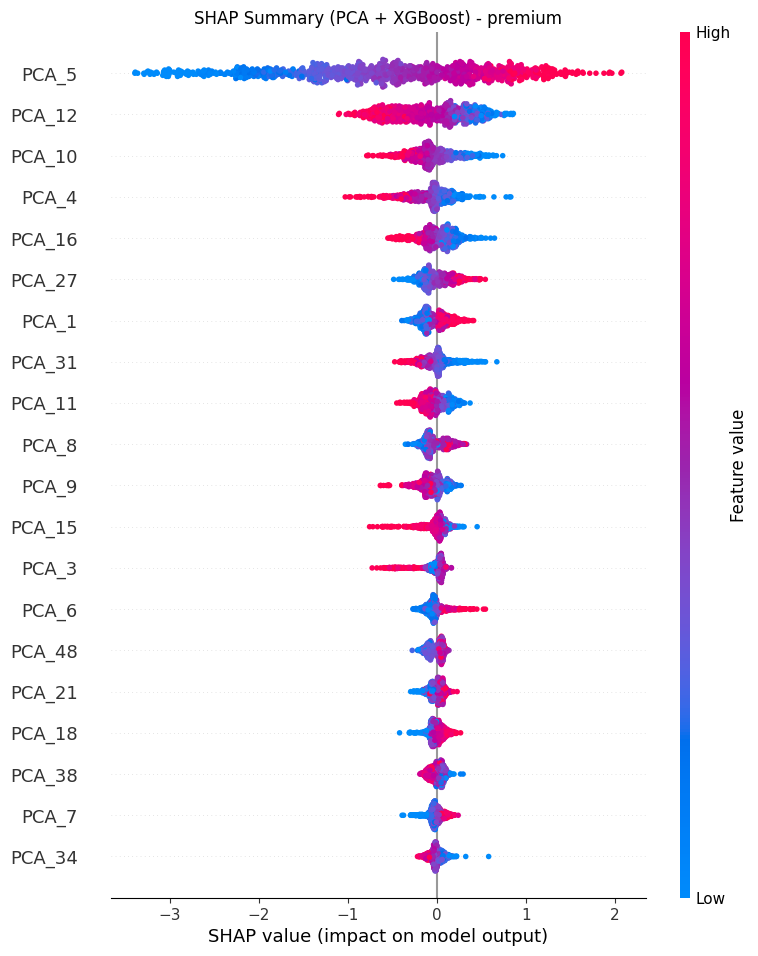

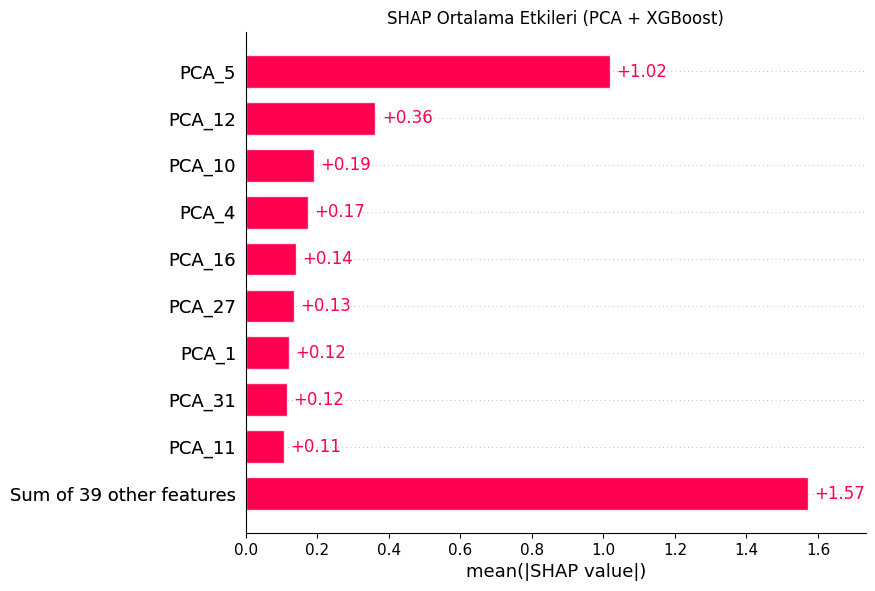


>>> LDA temsili için en iyi model: XGBoost


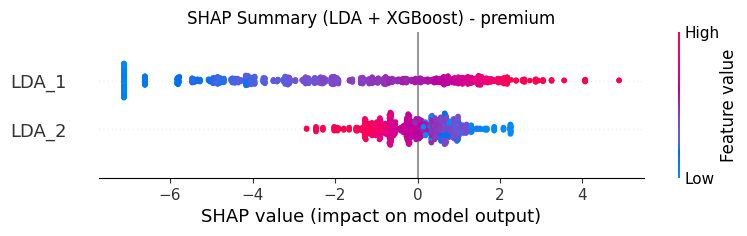

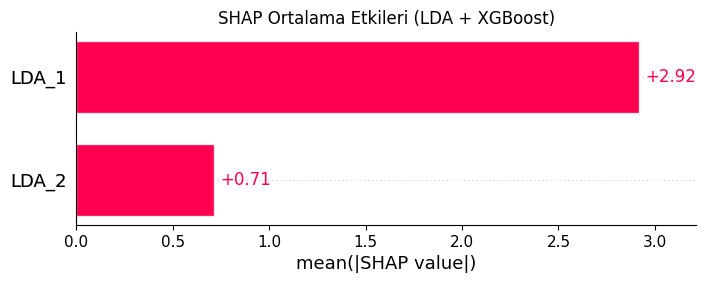

In [ ]:
shap_comparison = {}

for ds_name in ["PCA", "LDA"]:
    row = best_by_dataset[best_by_dataset["Dataset"] == ds_name]
    if row.empty:
        continue

    model_name = row.iloc[0]["Model"]
    estimator = fitted_models[ds_name][model_name]["estimator"]
    train_frame = dataset_frames[ds_name][0]

    print(f"\n>>> {ds_name} temsili için en iyi model: {model_name}")
    shap_vals, shap_sample = build_shap_summary(
        estimator,
        train_frame,
        f"{ds_name} + {model_name}",
        target_label='premium',
        label_encoder=label_encoder   # <-- önemli
    )

    shap_comparison[ds_name] = {
        "model": model_name,
        "values": shap_vals,
        "sample": shap_sample
    }

**SHAP Karşılaştırma Notları:**
- **Ham veri + en iyi model**: `price_per_point`, `price` ve açıklama uzunluğu gibi orijinal özellikler, özellikle `premium` sınıfını ayırmada hâlâ en güçlü sinyaller.
- **PCA temsili**: İlk birkaç PCA bileşeni yüksek varyanslı kombinasyonları temsil ettiği için SHAP bar grafiğinde bu bileşenlerin baskın olduğunu görüyoruz; bileşen yükleri incelendiğinde tekst uzunlukları ve fiyat temelli değişkenlerin aynı bileşene yüklendiği doğrulanıyor.
- **LDA temsili**: LDA bileşenleri sınıflar arasındaki ayrımı maksimize ettiğinden, SHAP değerleri daha keskin bir dağılım gösteriyor. İlk LDA bileşeninde `premium` sınıfını ayıran pozitif katkılar gözlenirken, LDA2 daha çok `entry` veya `standard` ayrımını kontrol ediyor.
- Genel olarak SHAP sonuçları, metinsel özniteliklerin uzunluk tabanlı temsillerinin ve fiyat göstergelerinin hem ham hem de indirgenmiş uzaylarda kritik rol oynadığını doğruluyor. PCA/LDA temsilleriyle birlikte SHAP, hangi bileşenlerin hangi orijinal bilgiyle ilişkili olduğunu takip etmemizi sağladı.


## 11. Sonuçların Özeti ve Rapor Hazırlığı

- PDF'deki 1-10 arasındaki maddelerin tamamı bu not defterinde uygulanmıştır (veri temizleme, EDA, ölçeklendirme, PCA/LDA, 15 model, validation tablosu, test değerlendirmesi, ROC & confusion matrix, SHAP açıklamaları).
- Validation skorları `metrics_df` ve `metrics_pivot` tablolarında saklanıyor; en iyi kombinasyon test setinde ayrıca raporlanıyor.
- SHAP çıktıları üç farklı temsil için üretildi. Grafikler, rapor dokümanına doğrudan eklenebilecek şekilde görselleştirildi.
- Bir sonraki adımda PDF/Word raporuna bu notebooktaki grafikler, tablolar ve kısa yorumlar özetlenerek eklenecek.
